In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%cd ../src

from ipc.training.config import *
import pandas as pd

from PIL import Image
import numpy as np
import seaborn as sns

/Users/mkalinowski/code/work/public_bin/ctw-7894/src


In [2]:
from IPython.display import display

def display_images(data_directory, annotations):
    for idx, row in annotations.iterrows():
        print(row)
        image = Image.open(data_directory/row.file_name).convert('RGB').resize((224, 224))
        display(image)
        print('\n\n')

In [3]:
from pathlib import Path
import torch

from ipc.datasets.image_dataset import ImageDatasetSettings, LightningImageDataset
from ipc.datasets.dataset_type import DatasetType
from ipc.losses.label_smoothing_cross_entropy import LabelSmoothingCrossEntropy
from ipc.models.efficient_net.implementations import EfficientNets
from ipc.models.efficient_net.main import EfficientNet, EfficientNetTrialInfo
from ipc.training.config import get_transformations


trial_info = EfficientNetTrialInfo(
    trial_root_path=Path('.'),
    epochs=3,
    batch_size=16,
    initial_lr=1e-3,
    optimizer=torch.optim.AdamW,
    num_classes=2,
    in_channels=3,
    loss=torch.nn.CrossEntropyLoss(),
    load_weights=True,
    adv_prop=False,
    freeze_pretrained_weights=False,
    optimizer_settings=dict(),
    scheduler_settings=dict(patience=3),
    custom_dropout_rate=None,
)
model = EfficientNet(net_info=EfficientNets.b0.value,
                     trial_info=trial_info)

model.load_state_dict(torch.load(Path('../notebooks') / 'model_sagemaker.pth'))
image_size = model.image_size

model = model.eval()

<All keys matched successfully>

In [4]:
assert not model.training

In [5]:
annotations = pd.read_csv(annotations_path).rename(columns={'new_file_name': 'file_name'})
annotations

path  label  \
0      data/input/custom/1/fire_inside_house/00000386...      1   
1      data/input/custom/1/fire_inside_house/00000467...      1   
2      data/input/custom/1/fire_inside_house/00000638...      1   
3      data/input/custom/1/fire_inside_house/00000074...      1   
4               data/input/custom/1/fire/00000120123.jpg      1   
...                                                  ...    ...   
17430   data/input/custom/0/garage_driveway/00000896.jpg      0   
17431   data/input/custom/0/garage_driveway/00000340.jpg      0   
17432   data/input/custom/0/garage_driveway/00000025.jpg      0   
17433   data/input/custom/0/garage_driveway/00000700.jpg      0   
17434   data/input/custom/0/garage_driveway/00000142.jpg      0   

              class_name file_name  is_test  
0      fire_inside_house     0.jpg        1  
1      fire_inside_house     1.jpg        0  
2      fire_inside_house    10.jpg        0  
3      fire_inside_house   100.jpg        0  
4                   fire  1000.jpg        0  
...                  ...       ...      ...  
17430    garage_driveway  9995.jpg        1  
17431    garage_driveway  9996.jpg        0  
17432    garage_driveway  9997.jpg        1  
17433    garage_driveway  9998.jpg        1  
17434    garage_driveway  9999.jpg        1  

[17435 rows x 5 columns]

In [6]:
from torch.utils.data import DataLoader
from ipc.datasets.image_dataset import ImageDataset
from sklearn.metrics import classification_report

def predict(model, data_loader):
    """
    Make predictions; additional info:
    - model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers
     will work in eval mode instead of training mode.
    - torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up
     computations but you won’t be able to backprop (which you don’t want in an eval script).
    """
    model.eval()

    target = torch.tensor([], dtype=torch.long, device=model.device)
    pred = torch.tensor([], device=model.device)

    with torch.no_grad():
        for data in data_loader:
            inputs = [i.to(model.device) for i in data[:-1]]
            labels = data[-1].to(model.device)

            outputs = model(*inputs)
            target = torch.cat((target, labels), 0)
            pred = torch.cat((pred, outputs), 0)

    _, pred_class = torch.max(pred, 1)

    model.train()
    return target, pred, pred_class

def get_predictions(model, dataset):
    preds = predict(model, val_dataloader)
    preds = pd.DataFrame({'actual': preds[0], 'pred':preds[2], 'numpy_preds': preds[1]})

    print(classification_report(preds.actual, preds.pred, target_names=['no_fire', 'fire']))
    
    return preds


test_annotations = annotations[annotations.is_test == 1]

val_dataset_settings = ImageDatasetSettings(val_data_directory, image_size, test_annotations,
                                            DatasetType.val,
                                            transformations=get_transformations(DatasetType.val, image_size))

val_dataloader = DataLoader(ImageDataset(val_dataset_settings),
          batch_size=64,
          shuffle=False,
          pin_memory=True,
          num_workers=4)

In [8]:
preds = predict(model, val_dataloader)
preds

(tensor([1, 0, 0,  ..., 0, 0, 0]),
 tensor([[-3.4986,  3.4700],
         [ 9.1624, -9.0421],
         [ 7.5287, -7.1258],
         ...,
         [ 7.8708, -7.3790],
         [ 4.9178, -4.6205],
         [ 9.4129, -8.9418]]),
 tensor([1, 0, 0,  ..., 0, 0, 0]))

In [9]:
def form_results_frame(preds):
    results = pd.DataFrame(preds[1].detach().numpy(), columns=['pred_0', 'pred_1'])
    results['actual'] = preds[0].detach().numpy().astype(bool)
    results['pred'] = preds[2].detach().numpy().astype(bool)
    results['model_right'] = results.actual == results.pred

    return results

results = form_results_frame(preds)

results = pd.concat([results, annotations[annotations.is_test ==1][['class_name', 'file_name', 'is_test']].reset_index(drop=True)], axis=1)
results

pred_0    pred_1  actual   pred  model_right         class_name  \
0     -3.498569  3.470019    True   True         True  fire_inside_house   
1      9.162357 -9.042067   False  False         True    garage_driveway   
2      7.528747 -7.125804   False  False         True    garage_driveway   
3      8.101134 -7.301167   False  False         True    garage_driveway   
4      5.360068 -5.047143   False  False         True    garage_driveway   
...         ...       ...     ...    ...          ...                ...   
4354  10.559484 -9.922997   False  False         True    garage_driveway   
4355   4.223724 -4.030558   False  False         True    garage_driveway   
4356   7.870814 -7.378958   False  False         True    garage_driveway   
4357   4.917752 -4.620515   False  False         True    garage_driveway   
4358   9.412860 -8.941832   False  False         True    garage_driveway   

      file_name  is_test  
0         0.jpg        1  
1     10002.jpg        1  
2     10006.jpg        1  
3     10011.jpg        1  
4     10014.jpg        1  
...         ...      ...  
4354   9994.jpg        1  
4355   9995.jpg        1  
4356   9997.jpg        1  
4357   9998.jpg        1  
4358   9999.jpg        1  

[4359 rows x 8 columns]

In [17]:
results.to_csv('../notebooks/results/results_valid.csv', index=False)

In [10]:
print(classification_report(results.actual, results.pred, target_names=['no_fire', 'fire']))

              precision    recall  f1-score   support

     no_fire       0.98      0.99      0.98      3374
        fire       0.95      0.94      0.94       985

    accuracy                           0.97      4359
   macro avg       0.96      0.96      0.96      4359
weighted avg       0.97      0.97      0.97      4359



In [74]:
import seaborn as sns

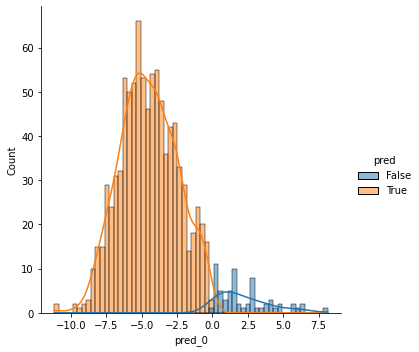

In [75]:
same_kwargs = dict(data=results[results.actual == 1], kde=True, hue='pred', alpha=.5, bins = 60)

sns.displot(x='pred_0', **same_kwargs)
sns.displot(x='pred_1', **same_kwargs)

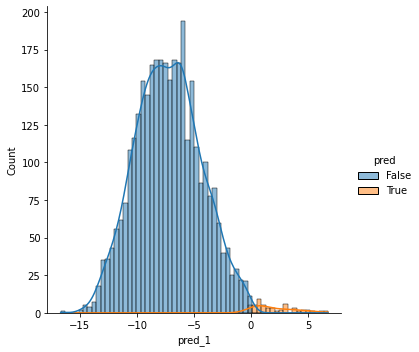

In [76]:
same_kwargs = dict(data=results[results.actual == 0], kde=True, hue='pred', alpha=.5, bins = 60)

sns.displot(x='pred_0', **same_kwargs)
sns.displot(x='pred_1', **same_kwargs)

In [80]:
(results[~results.model_right]
 .groupby(['actual', 'class_name'])
 .file_name.count()
 .to_frame()
 .sort_values(['actual', 'file_name'], ascending=False))

file_name
actual class_name                  
True   fire                      12
       house_fire                11
       car_burning               10
       smoke                     10
       fire_inside_house          6
       positives_found            5
       room_fire                  5
       kitchen_fire               3
       smoke2                     2
False  negatives_found           13
       house                      9
       clouds                     7
       cosy_interior              4
       garage_driveway            4
       christmass_tree            3
       kitchen_interior           2
       rain_clouds                2
       sunset                     2
       sunset_house               2
       desert_house               1
       driveway                   1

In [81]:
worst_negaive_cases = results[(~results.model_right) & (~results.actual)].sort_values('pred_1', ascending=False)
worst_negaive_cases

pred_0    pred_1  actual  pred  model_right        class_name  \
3801 -6.936376  6.761106   False  True        False            clouds   
2945 -6.480505  6.287238   False  True        False             house   
3898 -5.444842  5.292308   False  True        False            clouds   
1783 -5.297725  5.131648   False  True        False   christmass_tree   
3735 -4.928676  4.875916   False  True        False            clouds   
3136 -4.747336  4.499779   False  True        False             house   
4216 -4.747336  4.499779   False  True        False   negatives_found   
4259 -4.462693  4.399889   False  True        False   garage_driveway   
1569 -3.861479  3.831994   False  True        False  kitchen_interior   
1906 -3.858139  3.726109   False  True        False   negatives_found   
149  -3.720231  3.637751   False  True        False     cosy_interior   
1718 -3.322366  3.202057   False  True        False   garage_driveway   
1749 -3.322366  3.202057   False  True        False          driveway   
1712 -3.181632  3.097642   False  True        False   negatives_found   
3300 -3.118399  3.081573   False  True        False            sunset   
453  -3.056233  3.038344   False  True        False      sunset_house   
4237 -3.058291  2.863587   False  True        False   negatives_found   
1903 -2.792674  2.730564   False  True        False   negatives_found   
1713 -2.574251  2.519485   False  True        False   negatives_found   
3168 -2.121539  2.159061   False  True        False             house   
665  -2.040545  1.970147   False  True        False       rain_clouds   
4247 -1.899782  1.876801   False  True        False   negatives_found   
3158 -1.692543  1.692418   False  True        False             house   
4344 -1.499280  1.635235   False  True        False   garage_driveway   
3923 -1.417743  1.438838   False  True        False            clouds   
3141 -1.462200  1.402372   False  True        False             house   
2040 -1.305576  1.269488   False  True        False     cosy_interior   
3551 -1.272359  1.232797   False  True        False      desert_house   
4223 -0.960526  0.965559   False  True        False   negatives_found   
4234 -0.888879  0.907829   False  True        False   negatives_found   
376  -0.762740  0.905360   False  True        False      sunset_house   
3238 -0.862108  0.889233   False  True        False            sunset   
1905 -0.762768  0.787888   False  True        False   negatives_found   
4227 -0.846684  0.775524   False  True        False   negatives_found   
3719 -0.730585  0.664748   False  True        False            clouds   
364  -0.635786  0.647599   False  True        False     cosy_interior   
304  -0.681732  0.638391   False  True        False     cosy_interior   
2921 -0.532546  0.551082   False  True        False             house   
1637 -0.472422  0.528990   False  True        False       rain_clouds   
4265 -0.492563  0.510300   False  True        False   garage_driveway   
3043 -0.509680  0.491387   False  True        False             house   
1506 -0.452394  0.404852   False  True        False   christmass_tree   
4249 -0.340352  0.376435   False  True        False   negatives_found   
3037 -0.303487  0.374903   False  True        False             house   
4219 -0.255094  0.285566   False  True        False   negatives_found   
3072 -0.206962  0.101615   False  True        False             house   
1492 -0.367905  0.021170   False  True        False   christmass_tree   
1546 -0.367905  0.021170   False  True        False            clouds   
1883 -0.104785  0.012706   False  True        False  kitchen_interior   
3793 -0.187807 -0.060875   False  True        False            clouds   

       file_name  is_test  
3801    8075.jpg        1  
2945    4984.jpg        1  
3898    8419.jpg        1  
1783   16607.png        1  
3735    7842.jpg        1  
3136    5667.jpg        1  
4216    9483.jpg        1  
4259    9664.jpg        1  
1569  15723.jpeg        1  
1906

pred_0        -6.936376
pred_1         6.761106
actual            False
pred               True
model_right       False
class_name       clouds
file_name      8075.jpg
is_test               1
Name: 3801, dtype: object





pred_0        -6.480505
pred_1         6.287238
actual            False
pred               True
model_right       False
class_name        house
file_name      4984.jpg
is_test               1
Name: 2945, dtype: object





pred_0        -5.444842
pred_1         5.292308
actual            False
pred               True
model_right       False
class_name       clouds
file_name      8419.jpg
is_test               1
Name: 3898, dtype: object





pred_0               -5.297725
pred_1                5.131648
actual                   False
pred                      True
model_right              False
class_name     christmass_tree
file_name            16607.png
is_test                      1
Name: 1783, dtype: object





pred_0        -4.928676
pred_1         4.875916
actual            False
pred               True
model_right       False
class_name       clouds
file_name      7842.jpg
is_test               1
Name: 3735, dtype: object


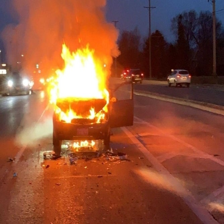

In [145]:
display_images(val_data_directory, worst_negaive_cases.head())

pred_0        -0.206962
pred_1         0.101615
actual            False
pred               True
model_right       False
class_name        house
file_name      5432.jpg
is_test               1
Name: 3072, dtype: object





pred_0               -0.367905
pred_1                 0.02117
actual                   False
pred                      True
model_right              False
class_name     christmass_tree
file_name           15454.jpeg
is_test                      1
Name: 1492, dtype: object





pred_0          -0.367905
pred_1            0.02117
actual              False
pred                 True
model_right         False
class_name         clouds
file_name      15664.jpeg
is_test                 1
Name: 1546, dtype: object


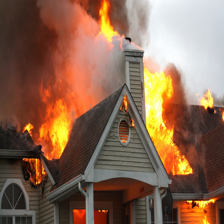




pred_0                -0.104785
pred_1                 0.012706
actual                    False
pred                       True
model_right               False
class_name     kitchen_interior
file_name             16976.png
is_test                       1
Name: 1883, dtype: object


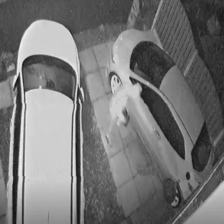




pred_0        -0.187807
pred_1        -0.060875
actual            False
pred               True
model_right       False
class_name       clouds
file_name      8046.jpg
is_test               1
Name: 3793, dtype: object


In [146]:
display_images(val_data_directory, worst_negaive_cases.tail())

In [85]:
worst_positive_cases = results[(~results.model_right) & (results.actual)].sort_values('pred_0', ascending=False)
worst_positive_cases

pred_0    pred_1  actual   pred  model_right       class_name  \
2487  8.143834 -7.943429    True  False        False  positives_found   
2587  6.340469 -6.257076    True  False        False             fire   
2598  6.266173 -5.781248    True  False        False             fire   
2278  6.073298 -5.977352    True  False        False     kitchen_fire   
2188  5.831871 -5.747267    True  False        False       house_fire   
...        ...       ...     ...    ...          ...              ...   
2539  0.232410 -0.592686    True  False        False      car_burning   
2607  0.162804 -0.014219    True  False        False        room_fire   
2091  0.129839 -0.083632    True  False        False       house_fire   
2247  0.113398 -0.193499    True  False        False       house_fire   
3447  0.021441 -0.104808    True  False        False      car_burning   

     file_name  is_test  
2487  3333.JPG        1  
2587  3696.png        1  
2598  3727.png        1  
2278  2594.jpg        1  
2188  2294.jpg        1  
...        ...      ...  
2539  3508.png        1  
2607   375.jpg        1  
2091  1942.jpg        1  
2247  2486.jpg        1  
3447   677.jpg        1  

[64 rows x 8 columns]

pred_0                8.143834
pred_1               -7.943429
actual                    True
pred                     False
model_right              False
class_name     positives_found
file_name             3333.JPG
is_test                      1
Name: 2487, dtype: object


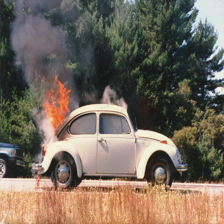




pred_0         6.340469
pred_1        -6.257076
actual             True
pred              False
model_right       False
class_name         fire
file_name      3696.png
is_test               1
Name: 2587, dtype: object





pred_0         6.266173
pred_1        -5.781248
actual             True
pred              False
model_right       False
class_name         fire
file_name      3727.png
is_test               1
Name: 2598, dtype: object


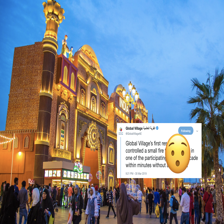




pred_0             6.073298
pred_1            -5.977352
actual                 True
pred                  False
model_right           False
class_name     kitchen_fire
file_name          2594.jpg
is_test                   1
Name: 2278, dtype: object


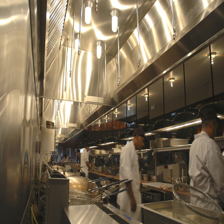




pred_0           5.831871
pred_1          -5.747267
actual               True
pred                False
model_right         False
class_name     house_fire
file_name        2294.jpg
is_test                 1
Name: 2188, dtype: object


In [147]:
display_images(val_data_directory, worst_positive_cases.head())

pred_0             0.23241
pred_1           -0.592686
actual                True
pred                 False
model_right          False
class_name     car_burning
file_name         3508.png
is_test                  1
Name: 2539, dtype: object


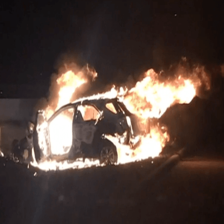




pred_0          0.162804
pred_1         -0.014219
actual              True
pred               False
model_right        False
class_name     room_fire
file_name        375.jpg
is_test                1
Name: 2607, dtype: object





pred_0           0.129839
pred_1          -0.083632
actual               True
pred                False
model_right         False
class_name     house_fire
file_name        1942.jpg
is_test                 1
Name: 2091, dtype: object


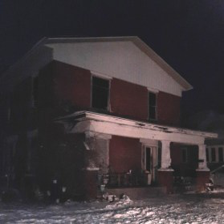




pred_0           0.113398
pred_1          -0.193499
actual               True
pred                False
model_right         False
class_name     house_fire
file_name        2486.jpg
is_test                 1
Name: 2247, dtype: object


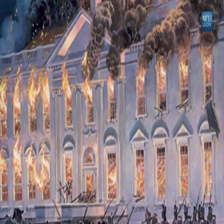




pred_0            0.021441
pred_1           -0.104808
actual                True
pred                 False
model_right          False
class_name     car_burning
file_name          677.jpg
is_test                  1
Name: 3447, dtype: object


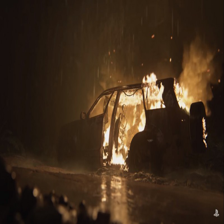

In [148]:
display_images(val_data_directory, worst_positive_cases.tail())

In [18]:
def annotate_files_in_folder(folder_prefix):
    results = pd.DataFrame()
    for label in [0, 1]:
        folder = folder_prefix / str(label)
        df = pd.DataFrame({'file_name': os.listdir(folder), 'label': label})
        df.file_name = df.label.apply(str) + '/' + df.file_name
        results = pd.concat([df, results])

    return results[~results.file_name.str.contains('.DS_Store')]

def get_dataloader_for_folder(folder_prefix, annotations, image_size=224, num_workers=4):
    val_dataset_settings = ImageDatasetSettings(folder_prefix, image_size, annotations,
                                                DatasetType.val,
                                                transformations=get_transformations(DatasetType.val, image_size))

    return DataLoader(ImageDataset(val_dataset_settings),
              batch_size=64,
              shuffle=False,
              pin_memory=True,
              num_workers=num_workers)


def run_prediction_pipeline_on_folder(folder_prefix, model):
    custom_annotations = annotate_files_in_folder(folder_prefix)

    data_loader = get_dataloader_for_folder(folder_prefix, custom_annotations)
    results = form_results_frame(predict(model, data_loader))
    return results, custom_annotations


folder_prefix = Path('../notebooks/test_images')

results, custom_annotations = run_prediction_pipeline_on_folder(folder_prefix, model)

results = pd.concat([results, custom_annotations.reset_index(drop=True)], axis=1)
results

pred_0     pred_1  actual   pred  model_right  \
0   -5.039640   4.896677    True   True         True   
1   -0.936277   0.979521    True   True         True   
2   -5.322979   5.189610    True   True         True   
3   -5.902120   5.835797    True   True         True   
4   -4.069131   4.078708    True   True         True   
5   -4.603362   4.466481    True   True         True   
6   -1.512723   1.506672    True   True         True   
7    7.465843  -7.733732   False  False         True   
8    6.713345  -7.144735   False  False         True   
9   10.084107 -10.625566   False  False         True   
10   4.987798  -4.910206   False  False         True   
11   0.631144  -0.618196   False  False         True   
12   2.477574  -2.578347   False  False         True   

                          file_name  label  
0                           1/8.jpg      1  
1   1/IMAGE 2021-02-24 12:44:17.jpg      1  
2               1/maxresdefault.jpg      1  
3                 1/images (1).jpeg      1  
4          1/fire-sunset-176393.jpg      1  
5               1/house_fire_xl.jpg      1  
6   1/IMAGE 2021-02-24 12:44:09.jpg      1  
7                   0/download.jpeg      0  
8                     0/images.jpeg      0  
9               0/download (1).jpeg      0  
10                  0/image (2).png      0  
11                  0/image (1).png      0  
12  0/5cd836142100005800ce22e7.jpeg      0

pred_0         -5.03964
pred_1         4.896677
actual             True
pred               True
model_right        True
file_name       1/8.jpg
label                 1
Name: 0, dtype: object


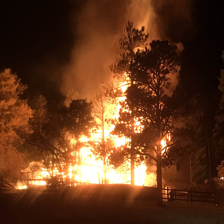




pred_0                               -0.936277
pred_1                                0.979521
actual                                    True
pred                                      True
model_right                               True
file_name      1/IMAGE 2021-02-24 12:44:17.jpg
label                                        1
Name: 1, dtype: object


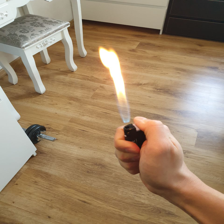




pred_0                   -5.322979
pred_1                     5.18961
actual                        True
pred                          True
model_right                   True
file_name      1/maxresdefault.jpg
label                            1
Name: 2, dtype: object


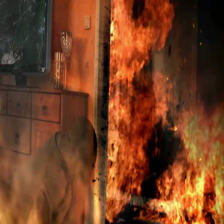




pred_0                  -5.90212
pred_1                  5.835797
actual                      True
pred                        True
model_right                 True
file_name      1/images (1).jpeg
label                          1
Name: 3, dtype: object


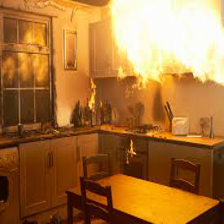




pred_0                        -4.069131
pred_1                         4.078708
actual                             True
pred                               True
model_right                        True
file_name      1/fire-sunset-176393.jpg
label                                 1
Name: 4, dtype: object


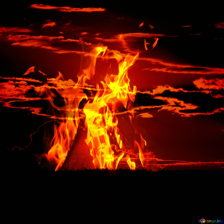




pred_0                   -4.603362
pred_1                    4.466481
actual                        True
pred                          True
model_right                   True
file_name      1/house_fire_xl.jpg
label                            1
Name: 5, dtype: object


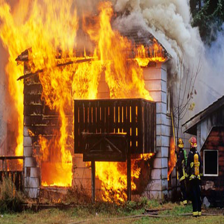




pred_0                               -1.512723
pred_1                                1.506672
actual                                    True
pred                                      True
model_right                               True
file_name      1/IMAGE 2021-02-24 12:44:09.jpg
label                                        1
Name: 6, dtype: object


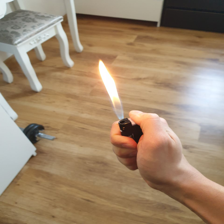




pred_0                7.465843
pred_1               -7.733732
actual                   False
pred                     False
model_right               True
file_name      0/download.jpeg
label                        0
Name: 7, dtype: object


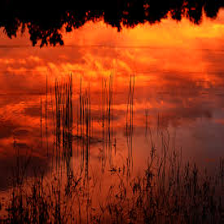




pred_0              6.713345
pred_1             -7.144735
actual                 False
pred                   False
model_right             True
file_name      0/images.jpeg
label                      0
Name: 8, dtype: object


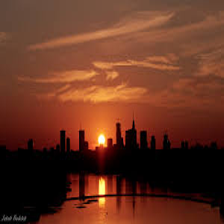




pred_0                   10.084107
pred_1                  -10.625566
actual                       False
pred                         False
model_right                   True
file_name      0/download (1).jpeg
label                            0
Name: 9, dtype: object


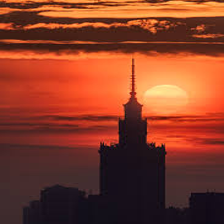




pred_0                4.987798
pred_1               -4.910206
actual                   False
pred                     False
model_right               True
file_name      0/image (2).png
label                        0
Name: 10, dtype: object


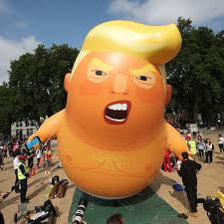




pred_0                0.631144
pred_1               -0.618196
actual                   False
pred                     False
model_right               True
file_name      0/image (1).png
label                        0
Name: 11, dtype: object





pred_0                                2.477574
pred_1                               -2.578347
actual                                   False
pred                                     False
model_right                               True
file_name      0/5cd836142100005800ce22e7.jpeg
label                                        0
Name: 12, dtype: object


In [19]:
display_images(folder_prefix, results)

In [27]:
transform_ops = get_transformations(DatasetType.val, image_size)

def predict_single_im(image, model):
    model.eval()
    im_transformed = transforms.Compose(transform_ops)(image).reshape([1, 3, 224, 224])
    with torch.no_grad():
        results = model(im_transformed)
    model.train()
    return results


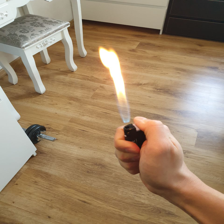

tensor([[-0.9363,  0.9795]])

In [28]:
image = Image.open(folder_prefix/'1/IMAGE 2021-02-24 12:44:17.jpg').convert('RGB')
display(image.resize((224,224)))
predict_single_im(image, model)

In [22]:
def quick_predict(numpy_image, model):
    image = Image.fromarray(numpy_image).convert('RGB')
    im_transformed = transforms.Compose(transform_ops)(image).reshape([1, 3, 224, 224])
    return model(im_transformed).detach().numpy()

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [32]:
import cv2
import time 

vid = cv2.VideoCapture(0) 
assert not model.training

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1
default_font_color     = (0,0,0)
lineType               = 2

try:
    while(True): 
        ret, frame = vid.read() 
        pred = quick_predict(frame, model)[0]
        pred_1 = softmax(pred)[1]
        print(f'{pred=}; {pred_1=}')

        time.sleep(1)

        fontColor = (255,0,0) if pred_1 > .25 else default_font_color
        cv2.imshow('frame', frame)
finally:
    vid.release() 
    cv2.destroyAllWindows() 

pred=array([ 4.4863377, -4.288056 ], dtype=float32); pred_1=0.00015461874
pred=array([ 4.214487, -4.055303], dtype=float32); pred_1=0.00025607343
pred=array([ 4.5728636, -4.434024 ], dtype=float32); pred_1=0.00012254775
pred=array([ 4.265188, -4.140935], dtype=float32); pred_1=0.0002234447
pred=array([ 4.1550517, -3.955709 ], dtype=float32); pred_1=0.0003002002
pred=array([ 4.032728 , -3.8221927], dtype=float32); pred_1=0.00038768843
pred=array([ 3.7936206, -3.6215348], dtype=float32); pred_1=0.0006016965
pred=array([ 4.079473 , -3.9563227], dtype=float32); pred_1=0.00032356216
pred=array([ 3.467599 , -3.2762885], dtype=float32); pred_1=0.0011766724
pred=array([ 4.3607755, -4.1260905], dtype=float32); pred_1=0.00020611587
pred=array([ 3.8339195, -3.6277943], dtype=float32); pred_1=0.0005743404
pred=array([ 4.3296766, -4.125937 ], dtype=float32); pred_1=0.00021265779
pred=array([ 4.1599264, -3.9338827], dtype=float32); pred_1=0.00030533085
pred=array([ 4.081907 , -3.8695915], dtype=floa

KeyboardInterrupt: 